# Importing modules and data from SemCor

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
from nltk.corpus import semcor
import pickle
import pandas as pd
from operator import itemgetter
import regex as re
from sklearn.model_selection import train_test_split, KFold
from numpy import array
import time
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
    

with open('data/semcor_transformed_data.pkl', 'rb') as handle:
    data_word_synset = pickle.load(handle)
with open('data/word_pos_DS.pkl', 'rb') as handle:
    data_word_pos = pickle.load(handle)

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
eta = 1e-10
def sense_transition(prev, curr):
    global countSense
    global sense_bigram_count
    global allSenses
    
    if prev not in allSenses or curr not in allSenses :
        return eta
    if countSense[prev]==0:
        return eta
    count = sense_bigram_count[(prev,curr)]
    return count/countSense[prev]

def N_gram(s_list, N=1):
    t = []
    for i in range(len(s_list)- N + 1):
        t.append( tuple(s_list[i:i+N]) )
    return t

def sense_emission(word, sense):
    global word_sense_count
    global word_count
    if (word,sense) not in word_sense_count.keys():
        return eta
    count = word_sense_count[(word,sense)]
    word_count_m = countSense[sense]
    if word_count_m == 0 :
        return eta
    return count/word_count_m

In [ ]:
def get_all_synsets(word,pos_list):
    syns = wn.synsets(word)
    if syns==[]:
        return ['']
    if '' in pos_list and len(pos_list)==1 :
        return ['']
    out_syn = []
    for s in syns:
        if s.pos() in pos_list:
            #match_word = s.name().split('.')
            #if type(match_word) == list and match_word[0]==word:
            out_syn.append(s.name())
    if out_syn == []:
        return ['']
    return out_syn

In [ ]:
def sense_assign_viterbi(words_list, pos_list):

    prev_sense = ['']
    # prev_v = [1]
    V = {}
    path = {}
    V[-1, ''] = 1
    path[''] = []
    for i in range(len(words_list)):

        temp_path ={}

        cur_sense = get_all_synsets(words_list[i], pos_list[i])


        for c_sense in cur_sense:
            #print(cur_sense, words_list)
            #print([(V[i-1,p_sense]*sense_transition(p_sense,c_sense)*sense_emission(words_list[i],c_sense),p_sense) for p_sense in prev_sense])
            V[i,c_sense],p_s = max([(V[i-1,p_sense]*sense_transition(p_sense,c_sense)*sense_emission(words_list[i],c_sense),p_sense) for p_sense in prev_sense])
            temp_path[c_sense] = path[p_s] + [c_sense]
            
        path = temp_path
        prev_sense = cur_sense
    
    prob, sense = max([(V[len(words_list)-1,s],s) for s in prev_sense ])
    return path[sense]



In [ ]:
def deleted_interpolation():
    global countSense
    global sense_trigram_count
    global sense_bigram_count
    
    l1 = l2 = l3 = 0
    sum_sense = sum(countSense.values())
    triplets = sense_trigram_count.keys() #[(a,b,c) for a in allTags for b in allTags for c in allTags]
    for a,b,c in triplets:
        triCount = sense_trigram_count[(a,b,c)]
        if triCount > 0:
            try: 
                k1 = (triCount-1)/(sense_bigram_count[(a,b)] - 1)
            except :
                k1 = 0.0
            try:
                k2 = (sense_bigram_count[(a,b)] - 1)/( countSense[a] - 1)
            except :
                k2 = 0.0
            try:
                k3 = ( countSense[a] - 1)/(sum_sense -1)
            except :
                k3 = 0.0
            #print(k1,k2,k3)
            k = np.argmax([k1, k2, k3])
            if k==0:
                l1 += triCount
            if k==1:
                l2 += triCount
            if k==2:
                l3 += triCount
    wts = [l1, l2, l3]
    return [l/(sum(wts)) for l in wts]

In [ ]:
def get_mfs(ws_count):
  word_all_senses = {}
  for k,v in zip(ws_count.keys(), ws_count.values()):
    if k[0] in word_all_senses.keys():
      if k[1] in word_all_senses[k[0]].keys():
        word_all_senses[k[0]][k[1]] += v
      else:
        word_all_senses[k[0]][k[1]] = v
    else:
      word_all_senses[k[0]] = {}
      word_all_senses[k[0]][k[1]] = v
  return word_all_senses

In [ ]:
## From trigram HMM
eta = 1e-10
def sense_transition(pp, prev, curr):
    global countSense
    global sense_bigram_count
    global sense_trigram_count
    global allSenses
    global sumSense
    global lambdas
    
    sense_uni, sense_bi, sense_tri = 0,0,0
    try:
        sense_uni = countSense[curr]/sumSense
    except:
        pass
    try:
        sense_bi = sense_bigram_count[(prev,curr)]/countSense[prev]
    except:
        pass
    try:
        sense_tri = sense_trigram_count[(pp, prev, curr)]/sense_bigram_count[(pp,prev)]
    except:
        pass
    if (sense_uni+sense_bi+sense_tri) == 0:
        return eta
    return lambdas[0]*sense_tri + lambdas[1]*sense_bi + lambdas[2]*sense_uni

def N_gram(s_list, N=1):
    t = []
    for i in range(len(s_list)- N + 1):
        t.append( tuple(s_list[i:i+N]) )
    return t

def sense_emission(word, sense):
    global word_sense_count
    global word_count
    if (word,sense) not in word_sense_count.keys():
        return eta
    count = word_sense_count[(word,sense)]
    word_count_m = countSense[sense]
    if word_count_m == 0 :
        return eta
    return count/word_count_m

In [ ]:
def train(train_set):
    global allSenses
    global train_data
    global countSense
    global word_sense_count
    global word_count
    global sense_bigram_count
    global sense_trigram_count
    global word_mfs
    
    train_data = train_set
    allSenses = {sense for sent in train_data for _,sense,_ in sent}
    countSense = Counter([t for sent in train_data for _,t,_ in sent])
    word_sense_count = Counter([(w,s) for sent in train_data for w,s,_ in sent])
    word_count = Counter([w for sent in train_data for w,_,_ in sent])
    word_mfs = get_mfs(word_sense_count)

    sense_bigram = []
    sense_trigram = []
    for sent in train_data:
        t = [s for _,s,_ in sent]
        sense_bigram += N_gram(t, N=2)
        sense_trigram += N_gram(t, N=3)
    


    sense_bigram_count = Counter(sense_bigram)
    sense_trigram_count = Counter(sense_trigram)
    
    
    

In [ ]:
def mfs(word,pos):
    global word_mfs
    word = word.lower()
    if word not in word_mfs.keys():
      return ''
    word_senses_count = word_mfs[word]
    if word_senses_count == {} : return ''
    # return word_senses_count.keys()
    syns = get_all_synsets(word,pos)
    t = {k:v for k,v in word_senses_count.items() if k in syns}
    word_senses_count = t
    if word_senses_count == {} : return ''
    s = max(word_senses_count, key=word_senses_count.get)
    if s == '' and len(word_senses_count) > 1:
        word_senses_count.pop('', None)
        return max(word_senses_count, key=word_senses_count.get)
    return s
def test_mfs(test_set):
  out_s = []
  for sent in test_set:
    out_s += [mfs(w,p) for w,_,p in sent]
  return out_s


def WFS(word,pos_list):
    global word_mfs
    # pos_list = ['n','s','a','v','r','']
    word = word.lower()
    s = get_all_synsets(word,pos_list)
    return s[0]
    

def test_WFS(test_set):
  out_s = []
  for sent in test_set:
    out_s += [WFS(w,p) for w,_,p in sent]
  return out_s



In [ ]:
def test(test_set):
    inp_s = []
    out_s = []
    for sent in test_set:
        sent_word = [w for w,_,_ in sent]
        inp_s    += [s for _,s,_ in sent]
        sent_pos  = [p for _,_,p in sent]
        out_s += sense_assign_viterbi(sent_word, sent_pos)
    return inp_s, out_s

In [ ]:
#semcor data transformation
def wordnet_pos_code(tag):
    if tag.startswith('NN'):
        return [wn.NOUN]
    elif tag.startswith('VB'):
        return [wn.VERB]
    elif tag.startswith('JJ'):
        return [wn.ADJ]
    elif tag.startswith('RB'):
        return [wn.ADV]
    else:
        return ['']

def word_pos(sent):
    out_sent = []
    for l in sent:
        w = []
        p = set()
        for tup in l:
            w.append(tup[0])
            p.add(tup[1])
        if None in p:
            p = {''}
        p = list(p)
        o_tag = []
        for tag in p:
            t = tag.split('|')
            for tg in t:
                o_tag.extend(wordnet_pos_code(tg))
        out_sent.append(('_'.join(w),list(set(o_tag))))
    return out_sent

def join_word_syn_pos(word_syn, word_pos):
    # sent wise join
    out_sent = []
    for tup_ws, tup_wp in zip(word_syn, word_pos):
        out_sent.append((tup_wp[0], tup_ws[1], tup_wp[1]))
    return out_sent

def word_synset_tuple(sent):
    out_tup = []
    for l in sent:
        if isinstance(l, nltk.tree.Tree):
            if hasattr(l.label(), '_name') :
                w,s = l.label().name(),l.label().synset().name()
            else :
                w,s = l.label().split('.')[0], ''
        else :
            w,s = l[0], ''
        out_tup.append( (w.lower(), s) )
    return out_tup
# uncomment to load your nltk_data and transform it
#nltk_data = list(semcor.tagged_sents(tag='sem'))
#data_word_synset = [word_synset_tuple(sent) for sent in nltk_data]

#x = semcor.tagged_sents(tag='pos')
#y = [[w.pos() for w in sent] for sent in x]
#data_word_pos = [word_pos(sent) for sent in y]

In [ ]:
semCorData = [join_word_syn_pos(sent_syn, sent_pos) for sent_syn, sent_pos in zip(data_word_synset, data_word_pos)]

In [ ]:
nltk_data = array(semCorData,dtype=object)

#Specifiying K for K-fold cross validations as 5
K_folds = KFold(5, True, 1)
actual_tags = []
predicted_tags =[]

mfs_output = []
i = 1
#Training  5 sets of predicted tags from 5 separate sets of train data iteratively
for train_data, test_data in K_folds.split(nltk_data):
    print("Iteration {} begins: ".format(i), end=" ")
    t_begin = time.time()
    # print('%d\ntrain: %s,\n\n\n %d\ntest: %s\n\n\n' % (len(nltk_data[train]),nltk_data[train][:2][:5], len(nltk_data[test]),nltk_data[test][:2][:5])) 
    train(nltk_data[train_data].tolist())
    test_list = nltk_data[test_data].tolist()
    tag_list, output_tags = test(test_list)
    actual_tags.append(tag_list)
    predicted_tags.append(output_tags)
    mfs_output.append(test_mfs(test_list))
    print("Time for {} run : {}".format(i,time.time() - t_begin))
    i += 1
    



Iteration 1 begins:  Time for 1 run : 16.12963557243347
Iteration 2 begins:  Time for 2 run : 13.37199854850769
Iteration 3 begins:  Time for 3 run : 13.113906383514404
Iteration 4 begins:  Time for 4 run : 13.340433120727539
Iteration 5 begins:  Time for 5 run : 13.020538568496704


In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def predict(sent):
    word_list = nltk.word_tokenize(sent)
    tagged_sent = nltk.pos_tag(word_list)
    words = [w for w,_ in tagged_sent]
    tags = [wordnet_pos_code(t) for _,t in tagged_sent]
    print(words,"\n",tags)
    return sense_assign_viterbi(words, tags)



In [ ]:
predict("He lit the candle with a match.")

In [ ]:
predict("I dont think our vibes match.")

In [ ]:
[(s,s.definition()) for s in wn.synsets('match') if s.pos()=='n']

[(Synset('match.n.01'),
  'lighter consisting of a thin piece of wood or cardboard tipped with combustible chemical; ignites with friction'),
 (Synset('match.n.02'),
  'a formal contest in which two or more persons or teams compete'),
 (Synset('match.n.03'), 'a burning piece of wood or cardboard'),
 (Synset('match.n.04'), 'an exact duplicate'),
 (Synset('match.n.05'), 'the score needed to win a match'),
 (Synset('catch.n.03'), 'a person regarded as a good matrimonial prospect'),
 (Synset('peer.n.01'),
  'a person who is of equal standing with another in a group'),
 (Synset('couple.n.02'), 'a pair of people who live together'),
 (Synset('match.n.09'), 'something that resembles or harmonizes with')]

In [ ]:
for j,k in zip(actual_tags[0][:10], predicted_tags[0][:10]):
    print(j,k)

 
september.n.01 september.n.01
october.n.01 october.n.01
term.n.02 terminus.n.03
jury.n.01 jury.n.02
 take.v.35
 exist.v.01
appoint.v.02 tear.v.03
 
location.n.01 fulton.n.01


In [ ]:
for j in range(5):
  print(len([1 for i in range(len(actual_tags[j])) if actual_tags[j][i]==predicted_tags[j][i] ] )/len(actual_tags[j]) )

0.6536861148801447
0.6526867963152507
0.6524275608101561
0.6517708716673223
0.6517478369631091


In [ ]:
for j in range(5):
  print(len([1 for i in range(len(actual_tags[j])) if actual_tags[j][i]==mfs_output[j][i] ] )/len(actual_tags[j]) )

0.7229631065451961
0.7226778403275332
0.7215880091740156
0.7217174473053056
0.7226735264915606


In [ ]:
print(metrics.classification_report(actual_tags[0], predicted_tags[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                                         0.97      0.73      0.84    109732
                                    a_battery.n.01       0.00      0.00      0.00         0
                                        a_bit.r.01       0.47      1.00      0.64        17
                                        a_few.s.01       0.58      1.00      0.73        36
                                   a_fortiori.r.01       1.00      1.00      1.00         1
                                      a_level.n.01       0.00      0.00      0.00         0
                                        a_lot.r.01       1.00      0.67      0.80         6
                                      abandon.v.01       0.50      1.00      0.67         1
                                      abandon.v.02       0.00      0.00      0.00         2
                                      abandon.v.04       1.00      0.50      0.

In [ ]:
# Gatehring measures for 5-folds 
overall_metrics = []
for i in range(5):
    overall_metrics.append(metrics.precision_recall_fscore_support(actual_tags[i], predicted_tags[i],average="macro"))

# Aggregating measures across 5-folds
agg_overall_metric = []
# Calculating Precision
agg_overall_metric.append((overall_metrics[0][0]+overall_metrics[1][0]+overall_metrics[2][0]+overall_metrics[3][0]+overall_metrics[4][0])/5)
# Calculating Recall
agg_overall_metric.append((overall_metrics[0][1]+overall_metrics[1][1]+overall_metrics[2][1]+overall_metrics[3][1]+overall_metrics[4][1])/5)
# Calculating F-1-Score
agg_overall_metric.append((2*agg_overall_metric[0]*agg_overall_metric[1])/(agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-0.5-Score
agg_overall_metric.append((1.25*agg_overall_metric[0]*agg_overall_metric[1])/(0.25 *agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-2-Score
agg_overall_metric.append((5*agg_overall_metric[0]*agg_overall_metric[1])/(4*agg_overall_metric[0]+agg_overall_metric[1]))


print(agg_overall_metric)
# print([i for i in range(100000)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.25153971987965845, 0.2816165475262643, 0.26572977496033134, 0.25702991171866146, 0.2750392109934371]


In [ ]:
sum(agg_overall_metric)/5

0.26619103301567054

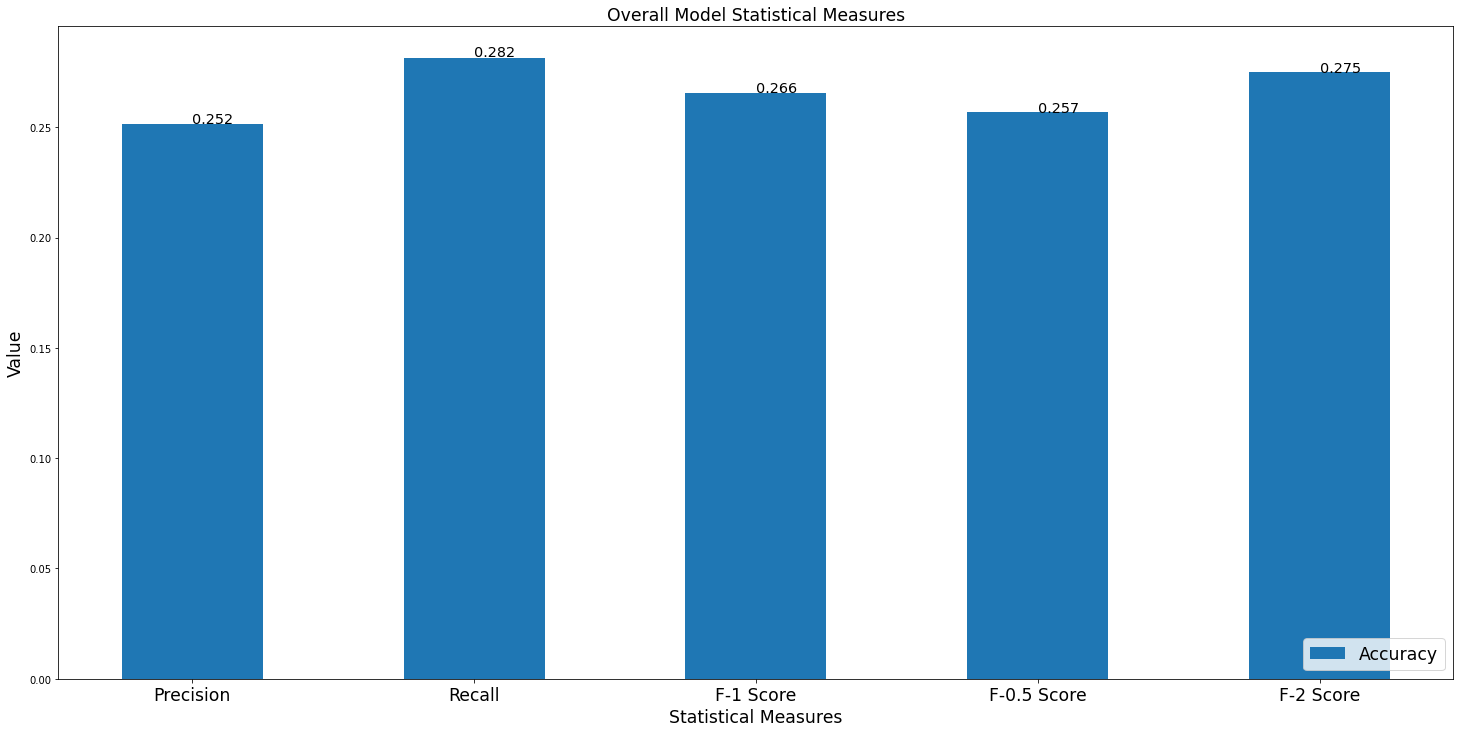

In [ ]:
# Plotting overall measures

def adding_labels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],fontsize='x-large')
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [25, 12]


width = 0.5

bar_1 =np.arange(5)
plt.bar(bar_1,agg_overall_metric,width,label="Accuracy")


adding_labels(["Precision","Recall","F-1 Score","F-0.5 Score","F-2 Score"], [round(x,3) for x in agg_overall_metric])

plt.xlabel("Statistical Measures",fontsize='xx-large')
plt.ylabel("Value",fontsize='xx-large')
plt.title("Overall Model Statistical Measures",fontsize='xx-large')
plt.xticks(bar_1,["Precision","Recall","F-1 Score","F-0.5 Score","F-2 Score"],fontsize='xx-large')
plt.legend(loc='lower right',fontsize='xx-large')
